In [1]:
import urllib, json
import geopandas as gpd
import matplotlib.pyplot as plt

# School coverage

data ref: Ravenna, November 2021  
data source: [Ravenna opendata](https://opendata.comune.ra.it/organization/comune-ravenna)  

**Indicator**: the aim of this indicator is to evaluate the coverage of schools. To do so it calculates the percentage of schools per grade per district and the coverage in relation to the affected segment of population.  
**Limitations**: population geolocalized data is not available publicly (GDPR), thus this example provides only the covered districts.

### Prepare data

In [2]:
areas_url = 'https://opendata.comune.ra.it/dataset/5ec2b0b3-24f7-4b75-987d-f53658d80064/resource/a8402fb2-3fd5-4a53-a691-263bb8e82640/download/sitra01aa01areeterritoriali.geojson'
areas_response = urllib.request.urlopen(areas_url)
areas_data = json.loads(areas_response.read())
#print(areas_data)
areas = gpd.GeoDataFrame.from_features(areas_data)
areas = areas[['geometry', 'NOME_AT']]
areas = areas.rename( columns = { 'NOME_AT' : 'frazione' } )
areas = areas.set_crs('epsg:4326')
areas = areas.to_crs( epsg = 32633 ) #utm
print(areas.head(3))

                                            geometry    frazione
0  POLYGON ((284232.269 4930649.527, 284235.500 4...    DEL MARE
1  POLYGON ((275721.083 4917396.486, 275668.926 4...  RONCALCECI
2  POLYGON ((271213.347 4927446.004, 271222.387 4...  PIANGIPANE


       classe             tipo                        geometry
0  Scolastico  Scuole Primaria  POINT (280595.706 4904318.283)
1  Scolastico  Scuole Primaria  POINT (281252.215 4920617.263)
2  Scolastico  Scuole Primaria  POINT (274122.332 4935857.147)


<AxesSubplot:>

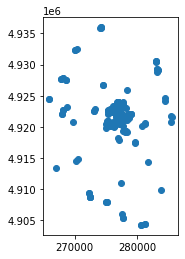

In [3]:
points_url = 'https://opendata.comune.ra.it/dataset/bde8e128-d925-4e53-b7c1-8464cc383eea/resource/544be0f6-d60c-4d14-93c2-a5c7db3d9baa/download/servizio_istruzione.json'
points_response = urllib.request.urlopen(points_url)
points_data = json.loads(points_response.read())
# print(points_data)
points = gpd.GeoDataFrame.from_features(points_data)
points = points[['CLASSE', 'TIPO', 'geometry']]
points = points.rename( columns = {'CLASSE' : 'classe', 'TIPO' : 'tipo'} )
# print(points.crs)
points = points.set_crs('epsg:3004')
points = points.to_crs( epsg = 32633 ) #utm
print(points.head(3))
points.plot()

   frazione       classe                              tipo  \
0  DEL MARE     Infanzia                   Nidi d'infanzia   
1  DEL MARE   Scolastico  Scuole Secondarie di Primo Grado   
2  DEL MARE  Universita'                       Universita'   

                         geometry  
0  POINT (283111.663 4929301.273)  
1  POINT (285450.797 4920808.373)  
2  POINT (283148.398 4928875.024)  


<AxesSubplot:>

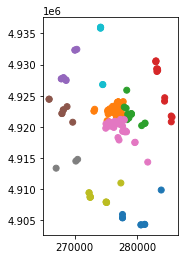

In [4]:
schools = areas.overlay( points, how = 'intersection', keep_geom_type = False )
print(schools.head(3))
schools.plot( column = 'frazione' )

In [5]:
def filter_order(school_type):
    df = schools[['frazione', 'tipo']]
    df = df[df['tipo'].str.contains(school_type)]
    df = df.rename( columns = { 'tipo' : 'num' } )
    df = df.groupby('frazione').count().reset_index()
    return df

# print(filter_order('Nidi d\'infanzia'))

In [6]:
def plotter(school_type):
    df = filter_order(school_type).merge( areas, on = 'frazione' )
    df = gpd.GeoDataFrame(df)
#     print(df.head(3))
#     print(isinstance(df, gpd.GeoDataFrame))
    base = df.plot( column = 'num', legend = True )
    areas.plot(ax = base, color = 'none', edgecolor = 'black')
    plt.title(school_type)

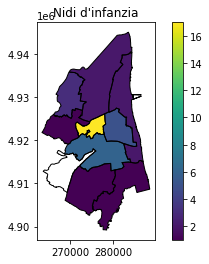

In [7]:
plotter('Nidi d\'infanzia')

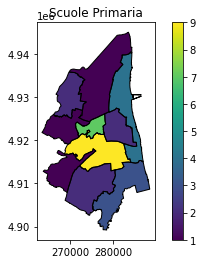

In [8]:
plotter('Scuole Primaria')

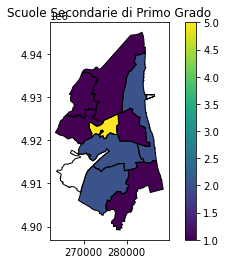

In [9]:
plotter('Scuole Secondarie di Primo Grado')

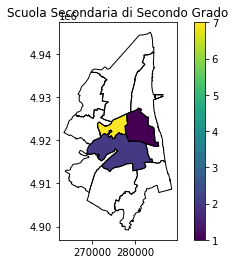

In [10]:
plotter('Scuola Secondaria di Secondo Grado')